# Final Project Submission
COMP0119: Acquisition and Processing of 3D Geometry (19/20)

**Nikolay Nikolov**  
MSc CGVI  
SN: 19063155  

**Chrysostomos Chadjiminas**  
MSc CGVI  
SN: 19109700  

Original paper: http://imagine.enpc.fr/~marletr/publi/SGP-2016-Boulch-Marlet.pdf

#### imports

In [0]:
%load_ext Cython
!pip install trimesh
import trimesh # Trimesh used to load obj

import random
import math
import os

import numpy as np
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

import tqdm # progressbar
from tqdm import tqdm
import pandas as pd
from collections import OrderedDict
import time
from copy import deepcopy
from IPython.display import clear_output

from torch.utils.data import Dataset      
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

     |████████████████████████████████| 614kB 3.5MB/s 
Using device: cuda



### 0 VIZ HELPERS

#### add_line

In [0]:
def add_line(fig, line, color='darkblue'):
  fig.add_trace(
    go.Scatter3d(x=line[:, 0], y=line[:, 1],  z=line[:, 2], 
                 marker=dict(
                     size=4,
                     color=color,
                     colorscale='Viridis',
                 ),
                 line=dict(color=color, width=2)
                )
    )

#### visualize_point_cloud

In [0]:
def visualize_point_cloud(points,
                          normals=None, 
                          normals_2=None,
                          title="Point Cloud",
                          fig=None,
                          colors=None,
                          size=4,
                          n_normals_to_visualise=300,
                          ):
  
  color = None
  if colors is None:
    color = points[:, 2]
  else:
    color = colors

  if fig is None: 
    fig = go.Figure()

  fig.add_trace(
    go.Scatter3d(
        x=points[:, 0], y=points[:, 1],  z=points[:, 2], 
        mode='markers', 
        marker=dict(color=color, size=size)
    )
  )

  if normals is not None:
    assert normals.shape[0] == points.shape[0]
    if n_normals_to_visualise > normals.shape[0]:
      n_normals_to_visualise = normals.shape[0]

    point_sample_idx = (np.random.random(n_normals_to_visualise) * points.shape[0]).astype(np.int)
    for i in point_sample_idx:
      i = int(i)
      point = points[i]
      normal = normals[i]
      normal = normal * 0.3
      normal_line = np.zeros([2, 3])
      normal_line[0, :] = point[:]
      normal_line[1, :] = point + normal
      add_line(fig, normal_line)
  
    if normals_2 is not None:
      if not isinstance(normals_2, list):
        normals_2 = [normals_2]
      for normals in normals_2:
        assert normals.shape[0] == points.shape[0]
        if n_normals_to_visualise > normals.shape[0]:
          n_normals_to_visualise = normals.shape[0]
    
        for i in point_sample_idx:
          i = int(i)
          point = points[i]
          normal = normals[i]
          normal = normal * 0.3
          normal_line = np.zeros([2, 3])
          normal_line[0, :] = point[:]
          normal_line[1, :] = point + normal
          add_line(fig, normal_line, color='red')

  fig.update_layout(
      title=title
  )

  # fig.show()
  return fig


#### visualize_dataset

#### plot_accumulator

In [0]:
def plot_accumulator(accumulator, fig=None):
  accumulator = accumulator.squeeze()
  if accumulator.ndim < 3:
    scales = 1
  else:
    scales = accumulator.shape[-1]

  if fig is None:
    fig = plt.figure(figsize=(12,12))
  if scales == 1:
    fig.imshow(accumulator)
  else:
    axes = fig.subplots(1, scales)
    for i, ax in enumerate(axes):
      ax.imshow(accumulator[..., i])
  

In [0]:
def visualize_dataset(dataset, scale_to_plot=0, n_accumulators=40, plot_size_scale=4.5):
  """ Plots accumulators of a dataset in a grid"""
  loader = DataLoader(dataset, batch_size=n_accumulators)

  for i, batch in enumerate(loader):
    accumulators = batch[0]
    # BatchSize x Channels x AccumSize x AccumSize
    accumulators = accumulators[:, scale_to_plot, :, :]
    accumulators = accumulators[:, None, :, :]
    print(accumulators.shape)
    batch_size=accumulators.shape[0]

    grid = torchvision.utils.make_grid(accumulators, 
                                       nrow=int(np.sqrt(batch_size)), normalize=True, pad_value=1, padding=1)
    
    plt.imshow(grid.permute(1, 2, 0).numpy(), cmap='Greys_r')
    fig = plt.gcf()
    size = fig.get_size_inches()
    fig.set_size_inches(size[0] * plot_size_scale, size[1] * plot_size_scale, forward=True) # Set forward to True to resize window along with plot in figure.
    plt.show()
    break

## 1 SYNTHETIC DATA GENERATION

#### random_points_triangle

In [0]:
def random_points_triangle(v1, v2, v3, num):
  points = np.zeros((num, 3))
  for i in range(num):
    w1 = random.random()
    upper = (1.0 - w1)

    ## Bias against flat
    ### TODO UNCOMMENT LATER
    # bias_mult = 0.75 - ((upper) * 0.60)
    # # bias_mult = 0.52 - ((upper) * 0.51)
    # bias_offset = 1 - bias_mult
    
    # side = random.random()
    # if side > 0.5:
    #   w2 = (random.random() * upper) * bias_mult + upper * bias_offset
    #   w3 = 1 - (w1 + w2)
    # else:
    #   w3 = (random.random() * upper) * bias_mult + upper * bias_offset
    #   w2 = 1 - (w1 + w3)

    # Normal
    w2 = random.random() * upper
    w3 = 1 - (w1 + w2)
    
    points[i, :] = v1 * w1 + v2 * w2 + v3 * w3

  return points

#### create_corner

In [0]:
def create_corner(n_points=5000, angle=90):
  ax1, ax2, ax3 = get_corner_axes(angle)

  p1 = np.array([0, 0, 0])
  # triangle 1
  p2 = ax1
  p3 = ax2
  n1 = np.cross(ax2, ax1)
  n1 /= np.linalg.norm(n1)
  points = random_points_triangle(p1, p2, p3, int(n_points/3))
  normals = np.zeros_like(points)
  normals[:] = n1
  
  # triangle 2
  p2 = ax1
  p3 = ax3
  n2 = -np.cross(ax3, ax1)
  n2 /= np.linalg.norm(n2)
  points = np.vstack((points, random_points_triangle(p1, p2, p3, int(n_points/3))))
  normals = np.vstack((normals, np.ones([int(n_points/3), 3])* n2))
  
  # triangle 2
  p2 = ax2
  p3 = ax3
  n3 = -np.cross(ax2, ax3)
  n3 /= np.linalg.norm(n3)
  points = np.vstack((points, random_points_triangle(p1, p2, p3, int(n_points/3))))
  normals = np.vstack((normals, np.ones([int(n_points/3), 3]) * n3))

  points[0, :] = ax1
  points[1, :] = ax2
  points[2, :] = ax3

  return points, normals

#### get_corner_axes

In [0]:
def get_corner_axes(angle=90):
  angle_rad = np.deg2rad(angle)

  rot = R.from_rotvec([0, -angle_rad, 0])

  ax1 = np.array([0, 0, -1])
  ax1 = R.from_rotvec([0, np.deg2rad(angle/2), 0]).apply(ax1)
  ax1 = ax1 / np.linalg.norm(ax1)

  ax2 = rot.apply(ax1.copy())
  ax2 = ax2 / np.linalg.norm(ax2)

  ax3dir = (ax1 + ax2) / 2

  if (angle <= 90):
    rot_w = angle / 90
    ax3 = ((1 - rot_w) * ax3dir + rot_w * np.cross(ax1, ax2)) / 2
  else:
    rot_w = 1 - ((angle - 90) / 90)
    ax3 = ((1 - rot_w) * -ax3dir + rot_w * np.cross(ax1, ax2)) / 2 
  
  ax3 = ax3 / np.linalg.norm(ax3)
  
  # flatten to third axes
  ax3flat = ax3.copy()
  ax3flat[2] = 0
  ax3flat = ax3flat / np.linalg.norm(ax3flat)
  r = rotation_matrix_from_vectors(ax3, ax3flat)
  
  if angle > 90:
    ax1 = r @ ax1.T
    ax2 = r @ ax2.T
    ax3 = r @ ax3.T

  mid = (ax1 + ax2) / 2
  
  # second rotation to balance sides
  axy = np.array([0, 1, 0])
  midmid = (mid + axy) / 2
  r = rotation_matrix_from_vectors(midmid, axy)
  
  ax1 = r @ ax1.T
  ax2 = r @ ax2.T
  ax3 = r @ ax3.T

  return ax1, ax2, ax3

#### rotation_matrix_from_vectors

In [0]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.

    SOURCE: https://stackoverflow.com/questions/45142959/calculate-rotation-matrix-to-align-two-vectors-in-3d-space
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

#### TEST Simple Corner Generation

In [0]:
angle = 120
corner, normals = create_corner(n_points=1000, angle=angle)
axes = np.array([[1,0,0], [0, 1, 0], [0, 0, -1]])
allcorners = np.vstack((corner, axes))
visualize_point_cloud(allcorners).show()

pass

## 2 HOUGH PROJECTION

### 2.1 Function Helpers

#### get_oriented_normals

In [0]:
def get_oriented_normals(normals, expected_directions=np.array([0, 0, 1])):
  """ Orients normals to be in the direction of expected directions

  Args:
    normals(np.array): Nx3 array of the normals to orient (flip sign)
    expected_directions(np.array): a vector or Nx3.
      Orients the normals based on expected directions.
      The dot product of the oriented normals with the expected directions is >0
  
  Returns:
    (np.array) : Nx3 array of the oriented normals OR
                 if input is a vector then returns a 3, vector.
  """

  normals.squeeze()
  expected_directions.squeeze()
  if normals.ndim == 1:
    normals = np.squeeze(normals)[np.newaxis, :]

  # If we have Nx3 directions we want to make sure that we have 
  # just as many normals.
  if expected_directions.ndim == 2:
    assert normals.ndim == 2
    assert normals.shape[0] == expected_directions.shape[0]
    
  signs = (normals @ expected_directions.T).T
  flip_idx = np.where(signs < 0)[0]
  normals[flip_idx] = -normals[flip_idx]

  return np.squeeze(normals)

#### get_max_vote_xy

In [0]:
def get_max_vote_xy(accumulator, accumulator_size=33):
    x, y = np.unravel_index(np.argmax(accumulator), accumulator.shape)

    nx = ((2 * x)/(accumulator_size-1)) - 1
    ny = ((2 * y)/(accumulator_size-1)) - 1

    return np.array([nx, ny])

#### get_normal_from_prediction

In [0]:
def get_normal_from_prediction(pred_n, pca_obj_3d=None, 
                               pca_obj_2d=None, 
                               expected_orientation=np.array([0, 0, 1])):
  
  x = pred_n[0]
  y = pred_n[1]
  # Some times we get negative error because of floating error
  # -> clip to range 0..1
  z = np.sqrt(np.clip(1 - (x**2 + y**2), 0 ,1))

  normal = np.array([x, y, z])
  if np.dot(normal, normal) < 0:
    print(np.dot(normal, normal))
    print(normal)
  normal /= np.sqrt(np.dot(normal, normal))
  normal = get_oriented_normals(normal, expected_orientation)

  if pca_obj_2d is not None:
    # print("applying 2d pca")
    if type(pca_obj_2d) == np.ndarray:
      normal = pca_obj_2d.T @ normal
    else:
      normal = pca_obj_2d.inverse_transform(normal)

  if pca_obj_3d is not None:
    # print("applying 3d pca") 
    if type(pca_obj_3d) == np.ndarray:
      normal = pca_obj_3d.T @ normal
    else:
      normal = pca_obj_3d.inverse_transform(normal)

  normal = get_oriented_normals(normal, expected_orientation)
  normal /= np.sqrt(np.dot(normal, normal))
  return normal

#### apply_random_rotation


In [0]:
def apply_random_rotation(points, normals=None):
  """ Applies random rotation to a point cloud and it's normals in place.
  """
  a, b, c = np.random.rand(3) * (np.pi)
  rot = R.from_rotvec((a * 0.2, b * 0.2, c))

  if normals is not None:
    normals = rot.apply(normals)
    normals = get_oriented_normals(normals, np.array([0, 0, 1]))
    return rot.apply(points), normals
  else:
    return rot.apply(points)

#### apply_noise

In [0]:


# CHANGES: Created apply noise function
# From https://github.com/mikedh/trimesh/blob/4cdf8f86acbe3e2841b9803fbd6a1a1d94dad3e9/trimesh/base.py#L48
# and https://github.com/mikedh/trimesh/blob/master/trimesh/permutate.py
def apply_noise(points, noise_scale=1):
  mesh_bounds = np.array([points.min(axis=0), points.max(axis=0)])
  extends = mesh_bounds.ptp(axis=0)
  scale = float((extends ** 2).sum() ** .5)
  magnitude = points * noise_scale / 100.0
  random = (np.random.random(points.shape) - .5) * magnitude
  points = points + random
  return points
# visualize_point_cloud(apply_noise(corner_points, noise_scale=100), corner_normals)

### 2.2 Accumulator

#### get_pca_transform

In [0]:
def get_pca_transform(points):
  # Mean centering points
  centroid = np.mean(points, axis=0)
  X = points - centroid

  
  cov = np.dot(X.T, X) / X.shape[0] 
  # assert is_pos_def(cov)
  # This is equivalent to
  # cov = np.zeros([3, 3])
  # for row in X:
  #   vec = row[:, np.newaxis]
  #   cov += vec @ vec.T
  # cov/X.shape[0]
  # Also equivalent to np.cov(X.T)
  
  _, _, vh = np.linalg.svd(cov, full_matrices=True)
  
  return vh

#### create_accumulator_vectorised

In [0]:
%%cython 

import cython 
from libc.math cimport round
from libc.stdlib cimport rand, RAND_MAX, srand
import numpy as np
from sklearn.decomposition import PCA

from __main__ import *

import __main__

cimport numpy as np

@cython.boundscheck(False)
# @cython.cdivision(True)
@cython.wraparound(False)
def get_random_triplets(int n, int n_triplets):
  srand(10)
  cdef int[:, :] triplets = np.empty([n_triplets, 3], dtype=np.int32)
  cdef int i
  cdef int a_idx, b_idx, c_idx

  for i in range(n_triplets):
    a_idx = int(round(rand() % n))
    b_idx = int(round(rand() % n))
    c_idx = int(round(rand() % n))
    while a_idx == b_idx or a_idx == c_idx or b_idx == c_idx:
      a_idx = int(round(rand() % n))
      b_idx = int(round(rand() % n))
      c_idx = int(round(rand() % n))

    triplets[i, 0] = a_idx
    triplets[i, 1] = b_idx
    triplets[i, 2] = c_idx

  return triplets

@cython.boundscheck(False)
@cython.wraparound(False)
cdef accumulate(int[:] accum_x, int[:] accum_y, int n_votes, float[:, :] accumulator_votes):
  cdef int i   
  cdef int j
  cdef int x
  cdef int y

  for i in range(n_votes):
      x = accum_x[i]
      y = accum_y[i]
      accumulator_votes[x, y] += 1

  

def create_accumulator_vectorised(points,
                                  apply_pca_3d=True,
                                  apply_pca_2d=True,
                                  accumulator_size=33,
                                  pca_transform_3d=None,
                                  pca_transform_2d=None,
                                  expected_orientation=np.array([0, 0, 1])):
  """ Create a hough accumulator from points.

  Args:
    points (np.array): Points as Nx3 array.
    accumulator_size (int): The size of the accumulator (accumulator will be mxm)
    expected_orientation (ndarray): Nx3 or 3, array.
      The orientation where the normals should look at.
      If Nx3 then takes the mean.
  
  Returns:
    (np.array) : The created accumulator (mxm).
  """ 
  pca_transform = None

  expected_orientation = np.squeeze(expected_orientation)
  # If more than one normals then expected orientation is the mean.
  if len(expected_orientation.shape) == 2:
    assert expected_orientation.shape[1] == 3
    expected_orientation = np.mean(expected_orientation, axis=0)
  else:
    assert len(expected_orientation.shape) < 2
    assert expected_orientation.shape[0] == 3

  cdef int T = 1000
  cdef int[:, :] triplet_idx = get_random_triplets(points.shape[0], T)

  triplets = points[triplet_idx]
  # triplets[0, 0] # The first point of the first triplet 

  points_a = triplets[:, 0]
  points_b = triplets[:, 1]
  points_c = triplets[:, 2]

  v1 = points_b - points_a
  v2 = points_c - points_a
  
  # random plane normals
  normals = np.cross(v1, v2)
  # transform, normalise, orient normals
  pca_transform_3d = None
  if apply_pca_3d:
    if pca_transform_3d is None:
      pca_transform_3d = get_pca_transform(points)
    normals = (pca_transform_3d @ normals.T).T
  normals = get_oriented_normals(normals, expected_orientation)
  normals /= np.linalg.norm(normals, ord=2, axis=1, keepdims=True)

  # accum_x = np.clip( ((normals[:, 0] + 1) / 2), a_min=0, a_max=1) * (accumulator_size - 1)
  # accum_y = np.clip( ((normals[:, 1] + 1) / 2), a_min=0, a_max=1) * (accumulator_size - 1)

  # vote
  accum_x = ((normals[:, 0] + 1) / 2) * (accumulator_size)
  accum_y = ((normals[:, 1] + 1) / 2) * (accumulator_size)

  # TODO: fix second PCA
  pca_transform_2d = None # remove this after
  if apply_pca_2d:
    if pca_transform_2d is None:
      hough_space = np.stack((accum_x, accum_y, np.zeros([accum_x.shape[0]])), axis=-1)
      pca_transform_2d = get_pca_transform(hough_space)

    normals = (pca_transform_2d @ normals.T).T
    normals = get_oriented_normals(normals, expected_orientation)
    normals /= np.linalg.norm(normals, ord=2, axis=1, keepdims=True)

    accum_x = ((normals[:, 0] + 1) / 2) * (accumulator_size)
    accum_y = ((normals[:, 1] + 1) / 2) * (accumulator_size)

  # cast votes coordinates to integer (floor)
  accum_x = (accum_x).astype(np.int32)
  accum_y = (accum_y).astype(np.int32)

  # create the accumulator
  accumulator_votes = np.zeros([accumulator_size, accumulator_size], dtype=np.float32)
  cdef float[:, :] accumulator_votes_view = accumulator_votes
  accumulate(accum_x, accum_y, accum_x.shape[0], accumulator_votes_view)
  accumulator_votes /= np.max(accumulator_votes)

  return accumulator_votes, pca_transform_3d, pca_transform_2d

### 2.3 Multiscale Accumulator

#### get_neighborhood

In [0]:
def get_neighborhood(points, point_idx, n_neighbors=100, kd_tree=None):
  point =  points[point_idx, :]
  point = point[np.newaxis, :]
    
  if kd_tree is None:
      kd_tree = KDTree(points)
        
  _, neighborhood_idx = kd_tree.query(point, n_neighbors)
  neighborhood = np.squeeze(points[neighborhood_idx])

  return neighborhood

#### get_random_neighborhood

In [0]:
def get_random_neighborhood(points, normals, n_neighbors=100, kd_tree=None):
  rand_idx = int(np.random.random() * (points.shape[0] - 1))

  return rand_idx, get_neighborhood(points, rand_idx, n_neighbors=n_neighbors, kd_tree=kd_tree)

#### create_multiscale_accumulator

In [0]:
def create_multiscale_accumulator(point_cloud,
                                  point_idx,
                                  apply_pca_3d=True,
                                  apply_pca_2d=True,
                                  accumulator_size=33, 
                                  k=100, scales=3,
                                  kd_tree=None):
  if kd_tree is None:
    kd_tree = KDTree(point_cloud)

  if scales == 3:
    accumulator = np.zeros([accumulator_size, accumulator_size, 3])
    
    # k
    neighborhood = get_neighborhood(point_cloud, point_idx, n_neighbors=k, kd_tree=kd_tree)
    accum, pca3, pca2 = create_accumulator_vectorised(neighborhood, 
                                                      apply_pca_3d=apply_pca_3d,
                                                      apply_pca_2d=apply_pca_2d)
    accumulator[:, :, 1] = accum

    # k/2
    neighborhood = get_neighborhood(point_cloud, point_idx, n_neighbors=int(k*0.5), kd_tree=kd_tree)
    accum, _, _ = create_accumulator_vectorised(neighborhood,
                                                apply_pca_3d=apply_pca_3d,
                                                apply_pca_2d=apply_pca_2d,
                                                pca_transform_3d=pca3,
                                                pca_transform_2d=pca2)
    accumulator[:, :, 0] = accum
    # 2*k
    neighborhood = get_neighborhood(point_cloud, point_idx, n_neighbors=int(k*2), kd_tree=kd_tree)
    accum, _, _ = create_accumulator_vectorised(neighborhood,
                                                apply_pca_3d=apply_pca_3d,
                                                apply_pca_2d=apply_pca_2d,
                                                pca_transform_3d=pca3,
                                                pca_transform_2d=pca2)
    accumulator[:, :, 2] = accum

  if scales == 5:
    accumulator = np.zeros([accumulator_size, accumulator_size, 5]) 
    # k
    neighborhood = get_neighborhood(point_cloud, point_idx, n_neighbors=k, kd_tree=kd_tree)
    accum, pca3, pca2 = create_accumulator_vectorised(neighborhood, 
                                                      apply_pca_3d=apply_pca_3d,
                                                      apply_pca_2d=apply_pca_2d)
    accumulator[:, :, 2] = accum

    # 2*k
    neighborhood = get_neighborhood(point_cloud, point_idx, n_neighbors=2*k, kd_tree=kd_tree)
    accum, _, _ = create_accumulator_vectorised(neighborhood,
                                                apply_pca_3d=apply_pca_3d,
                                                apply_pca_2d=apply_pca_2d,
                                                pca_transform_3d=pca3,
                                                pca_transform_2d=pca2)
    accumulator[:, :, 3] = accum

    # 4*k
    neighborhood = get_neighborhood(point_cloud, point_idx, n_neighbors=4*k, kd_tree=kd_tree)
    accum, _, _ = create_accumulator_vectorised(neighborhood,
                                                apply_pca_3d=apply_pca_3d,
                                                apply_pca_2d=apply_pca_2d,
                                                pca_transform_3d=pca3,
                                                pca_transform_2d=pca2)
    accumulator[:, :, 4] = accum

    # k/2
    neighborhood = get_neighborhood(point_cloud, point_idx, n_neighbors=int(k*0.25), kd_tree=kd_tree)
    accum, _, _ = create_accumulator_vectorised(neighborhood,
                                                apply_pca_3d=apply_pca_3d,
                                                apply_pca_2d=apply_pca_2d,
                                                pca_transform_3d=pca3,
                                                pca_transform_2d=pca2)
    accumulator[:, :, 1] = accum
    # k/4
    neighborhood = get_neighborhood(point_cloud, point_idx, n_neighbors=int(k*0.5), kd_tree=kd_tree)
    accum, _, _ = create_accumulator_vectorised(neighborhood,
                                                apply_pca_3d=apply_pca_3d,
                                                apply_pca_2d=apply_pca_2d,
                                                pca_transform_3d=pca3,
                                                pca_transform_2d=pca2)
    accumulator[:, :, 0] = accum
  return accumulator, pca3, pca2

#### get_angle_erorr

In [0]:
# 0.139626 rad ~= 8 deg
def get_angle_error(normals_a, normals_b, pgp_threshold=0.139626):
    """ Measure angle error bettween two sets of normals
    
    Sum the angle difference between the normals and count
    the number of normals that have smaller angle than pgp_threshold.

    Get the reconstructed mean error, the number of correctly calculated normals
    
    Args:
        normals_a(np.array): shape(N,3)
        normals_b(np.array): shape(N,3)
        pgp_threshold(float): The maximum acceptable angle between
            two normals. Every pair of normals that have angle < max_acceptable_angle
            is considered good.
    Returns:
        (float, int, array) 
        * The reconstruction mean error (rms), 
        * Number of pairs that have angle < pgp_threshold,
        * Indices of points that have normal pairs with angle angle < pgp_threshold
    """
    assert normals_a.ndim == 2 and normals_b.ndim == 2

    dots = np.einsum('ij,ij->i', normals_a, normals_b)
    dots = np.clip(dots, 0 ,1)
    angles = np.arccos(dots)
    angles_sq = angles**2

    angles_sq[np.isnan(angles_sq)] = 0
    
    good_points_idx = np.where(angles < pgp_threshold)[0]
    n_good_points = len(good_points_idx)

    return np.sqrt(np.sum(angles_sq) / n_good_points), n_good_points, good_points_idx

### TEST Hough projection


In [0]:
# np.random.seed(1)

min_angle = 80
max_angle = 160

min_noise = 2
max_noise = 5

random_angle = math.floor(min_angle + np.random.random() * (max_angle - min_angle))
random_noise = min_noise + np.random.random() * (max_noise - min_noise)

print(random_angle)
print(random_noise)

corner, normals = create_corner(angle=random_angle)
corner, normals = apply_random_rotation(corner, normals)
corner = apply_noise(corner, random_noise)

axes = np.array([[1,0,0], [0, 1, 0], [0, 0, -1]])
allcorners = np.vstack((corner, axes))
visualize_point_cloud(allcorners).show()


152
2.4900060952055014


[[-0.84138724  0.53620709  0.06744979]
 [-0.51322526 -0.83188229  0.21112008]
 [ 0.16931437  0.1430168   0.97513016]]
[[ 0.01399245  0.9999021   0.        ]
 [ 0.9999021  -0.01399245 -0.        ]
 [ 0.          0.          1.        ]]


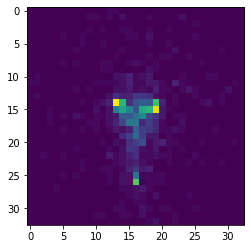

In [0]:
accumulator_votes, pca_transform_3d, pca_transform_2d  = create_accumulator_vectorised(
                                                          corner,
                                                          apply_pca_3d=True,
                                                          apply_pca_2d=True)

print(pca_transform_3d)
print(pca_transform_2d)

plt.imshow(accumulator_votes)
visualize_point_cloud(corner, normals).show()
pass

# TODO
# Q: Why is it rotating every time?
# A: PCA is unstable for corner
# Q: When I turn off PCAs it's not rotating but voting seem to change
# A: Neighborhood sampling probably
# Q: why do i get noisy votes on a flat corner plane
# A: Sampling around edges

In [0]:
kd_tree = KDTree(corner, metric='euclidean')

0.0018728681782386298
[0.0625 0.5   ]
[-0.17504307 -0.40380647  0.89794224]


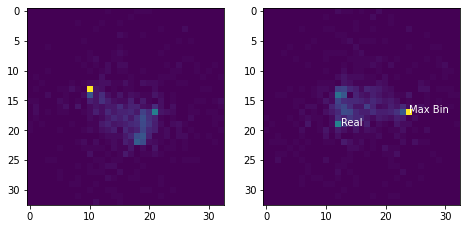

In [0]:
# np.random.seed(142)
# np.random.seed(147)

# get a random point and its normal from the point cloud
dist = 42
while dist > 0.02:
  rand_idx = int(np.random.rand() * (corner.shape[0] - 1))
  random_point = corner[rand_idx]
  dist = np.linalg.norm(random_point)

print(dist)

# rand_idx = int(np.random.rand() * (corner.shape[0] - 1))
# random_point = corner[rand_idx]
random_normal = normals[rand_idx]

# sample neighborhood
_, neighbors_idx = kd_tree.query(random_point[np.newaxis, :], k=100)
neighborhood =  np.squeeze(corner[neighbors_idx])

plt.figure(figsize=(12,12))


accum_votes1, pca_3d, pca_2d = create_accumulator_vectorised(neighborhood,
                                                    apply_pca_3d=False,
                                                    apply_pca_2d=False)
plt.subplot(131)
plt.imshow(accum_votes1)

accum_votes2, pca_3d, pca_2d = create_accumulator_vectorised(neighborhood,
                                                    apply_pca_3d=True,
                                                    apply_pca_2d=False)
plt.subplot(132)
# plt.imshow(accum_votes2)

# accum_votes3, pca_3d, pca_2d = create_accumulator_vectorised(neighborhood,
#                                                     apply_pca_3d=True,
#                                                     apply_pca_2d=True)
# plt.subplot(133)
# plt.imshow(accum_votes3)

# ground_truth_hough = pca_2d @ (pca_3d @ random_normal) 
ground_truth_hough = (pca_3d @ random_normal) 
accum_x = ((ground_truth_hough[0] + 1) / 2) * (33)
accum_y = ((ground_truth_hough[1] + 1) / 2) * (33)

plt.imshow(accum_votes2)

maxx, maxy = np.unravel_index(np.argmax(accum_votes2), accum_votes2.shape)

plt.annotate('Real', xy=(accum_y, accum_x), xycoords='data', color='white')
# plt.scatter(accum_y, accum_x, s=50, c='green', marker='o')

plt.annotate('Max Bin', xy=(maxy, maxx), xycoords='data', color='white')
# plt.scatter(maxy, maxx, s=50, c='blue', marker='o')

fig = go.Figure()
fig = visualize_point_cloud(corner, fig=fig, size=4)
ps = neighborhood
fig.add_trace(go.Scatter3d(x=ps[:, 0], 
                           y=ps[:, 1],  
                           z=ps[:, 2], 
                           mode='markers',
                           marker=dict(color='#AAD')
                           ))

# get the xy coord for the most voted bin
normal_xy = get_max_vote_xy(accum_votes2)
print(normal_xy)

predicted_normal = get_normal_from_prediction(normal_xy, pca_3d, None)
print(predicted_normal)

point = random_point
normal = random_normal
normal = normal * 0.3
normal_line = np.zeros([2, 3])
normal_line[0, :] = point[:]
normal_line[1, :] = point + normal
add_line(fig, normal_line)

point = random_point
normal = predicted_normal
normal = normal * 0.6
normal_line = np.zeros([2, 3])
normal_line[0, :] = point[:]
normal_line[1, :] = point + normal
add_line(fig, normal_line)

fig.show()

In [0]:
fig2 = go.Figure(fig)
# get the xy coord for the most voted bin
normal_xy = get_max_vote_xy(accum_votes2)
print(normal_xy)

predicted_normal = get_normal_from_prediction(normal_xy, pca_3d, pca_3d)
print(predicted_normal)

point = random_point
normal = random_normal
normal = normal * 0.3
normal_line = np.zeros([2, 3])
normal_line[0, :] = point[:]
normal_line[1, :] = point + normal
add_line(fig2, normal_line)

point = random_point
normal = predicted_normal
normal = normal * 0.6
normal_line = np.zeros([2, 3])
normal_line[0, :] = point[:]
normal_line[1, :] = point + normal
add_line(fig2, normal_line)

fig2.show()

[0.0625 0.5   ]
[0.44276769 0.29626585 0.84627615]


###### Multiscale accumulator

In [0]:
accum_multiscale, _, _= create_multiscale_accumulator(corner, 50, scales=5)

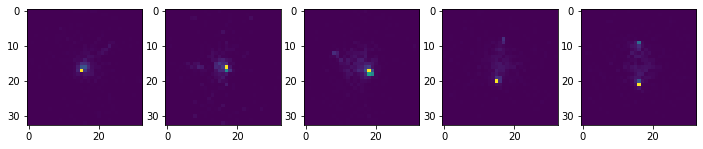

In [0]:
plot_accumulator(accum_multiscale)

### Generate training data


#####  HoughTransformDataset

In [0]:
class HoughTransformDataset(Dataset):
  """ Used to create a DataLoader compliant Dataset

  DataLoaders allow for easier batching and sampling.
  """
  def __init__(self, 
               hough_accumulators, 
               normals,
               accumulator_size=33):
    """ Create a hough transform - normal dataset

    Args:
      hough_accumulators (ndarray): 
          The hough accumulators training images.
          shape -> N x accumulator_size x accumulator_size
      normals (ndarray):
          The corresponding normals for each hough accumulator.
          shape -> N x 3
    """
    assert hough_accumulators.ndim == 4
    assert hough_accumulators.shape[1] == accumulator_size
    assert hough_accumulators.shape[2] == accumulator_size

    self.n_acucmulators = hough_accumulators.shape[0]
    self.n_channels = hough_accumulators.shape[-1]

    assert normals.shape[0] == hough_accumulators.shape[0]
    assert normals.shape[1] == 2
    print(hough_accumulators.shape)

    hough_accumulators.transpose(0, -1, 1, 2)

    self.transform = transforms.Compose([
        # you can add other transformations in this list
        transforms.ToTensor()
    ])

    self.samples = [(accum, normal) for accum, normal in zip(hough_accumulators, normals)]
    # print("HoughTransformDataset::Samples ", self.samples)
    # print("HoughTransformDataset::Normals", normals)

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    sample = self.samples[idx]

    accumulator, normal = sample[0], sample[1]

    accumulator = self.transform(accumulator)
    return accumulator, normal

##### create_dataset


In [0]:
def create_dataset(n_samples,
                   scales=5,
                   neighberhood_size=100,
                   n_points_per_neighborhood=100,
                   apply_pca_3d=True,
                   apply_pca_2d=True,
                   accumulator_size=33):
  n_points_per_corner = 5000
  n_neighborhoods_per_corner = 1000
  
  min_angle = 80
  max_angle = 160

  min_noise = 1
  max_noise = 35

  corner_3_ratio = 0.43
  corner_2_ratio = 0.43

  n_corner_3 = int(n_samples * corner_3_ratio)
  n_corner_2 = int(n_samples * corner_2_ratio)
  n_corner_1 = n_samples - (n_corner_3 + n_corner_2)
  
  print()
  print("Target 3-corner: ", n_corner_3)
  print("Target 2-corner: ", n_corner_2)
  print("Target 1-corner: ", n_corner_1)

  count_corner_3 = 0
  count_corner_2 = 0
  count_corner_1 = 0

  assert neighberhood_size <= n_points_per_corner 
  assert min_angle <= max_angle 

  hough_accumulators = np.zeros([n_samples, accumulator_size, accumulator_size, scales],
                                dtype=np.float32)
  normals = np.zeros([n_samples, 2], dtype=np.float32)

  with tqdm(total=n_samples) as progress_bar:
    count_samples = 0
    while count_samples < n_samples:
      random_angle = math.floor(min_angle + np.random.random() * (max_angle - min_angle))
      random_noise = min_noise + np.random.random() * (max_noise - min_noise)

      corner_points, corner_normals = create_corner(n_points_per_corner,
                                                    random_angle)    
      corner_points, corner_normals = apply_random_rotation(corner_points, 
                                                            corner_normals)
      corner_points = apply_noise(corner_points, noise_scale=random_noise)

      kd_tree = KDTree(corner_points, metric='euclidean')
      # Select random points for this corner to create neighborhoods from
      random_points_idx = (np.random.random(n_neighborhoods_per_corner) * corner_points.shape[0]).astype(np.int)
      # print(random_points_idx)

      random_points = corner_points[random_points_idx]
      random_normals = corner_normals[random_points_idx]
      # print("Random Normals", random_normals)

      # Search for edges and 3-corners in a smaller neighborhood_size so that
      # votes are more prominent
      _, neighborhoods_idx = kd_tree.query(random_points, k=int(neighberhood_size*0.20))

      i = 0
      while i < neighborhoods_idx.shape[0]:
        if count_samples >= n_samples:
          break
        curr_point_idx = random_points_idx[i]
        curr_normal = random_normals[i]
        curr_point_neighbors = corner_points[neighborhoods_idx[i]]
        curr_point_normals = corner_normals[neighborhoods_idx[i]]

        n_different_normals = np.unique(curr_point_normals[:, 0].round(decimals=2), axis=0).shape[0]

        i += 1
        if n_different_normals == 3:
          if count_corner_3 >= n_corner_3:
            continue
          else:
            count_corner_3 += 1
        elif n_different_normals == 2:
          if count_corner_2 >= n_corner_2:
           continue
          else:
            count_corner_2 += 1
        elif  n_different_normals == 1:
          if count_corner_1 >= n_corner_1:
           continue
          else:
            count_corner_1 += 1
        
        # print(n_different_normals)

        # print(curr_point_neighbors.shape)
        accum_votes, pca_obj_3d, pca_obj_2d = create_multiscale_accumulator(corner_points,
                                                    curr_point_idx,
                                                    scales=scales,                       
                                                    apply_pca_3d=apply_pca_3d,
                                                    apply_pca_2d=apply_pca_2d,
                                                    accumulator_size=accumulator_size,
                                                    )

        # Fill in the training sample 
        hough_accumulators[count_samples, ...]  = accum_votes

        # label is the pca transformed normal
        normal = curr_normal

        if pca_obj_3d is not None:
          normal = pca_obj_3d @ normal

        if pca_obj_2d is not None:
          normal = pca_obj_2d @ normal

        normal /= np.linalg.norm(normal)
        normal = normal[:-1]
        normals[count_samples, :] = normal

        count_samples += 1
        progress_bar.update(1)
  print()
  print(f"Generated {count_corner_1} planes")
  print(f"Generated {count_corner_2} 2-corners")
  print(f"Generated {count_corner_3} 3-corners")

  return HoughTransformDataset(hough_accumulators, normals, accumulator_size)

##### TEST

  8%|▊         | 8/100 [00:00<00:01, 79.25it/s]


Target 3-corner:  43
Target 2-corner:  43
Target 1-corner:  14


100%|██████████| 100/100 [00:01<00:00, 80.61it/s]



Generated 14 planes
Generated 43 2-corners
Generated 43 3-corners
(100, 33, 33, 5)
torch.Size([100, 1, 33, 33])


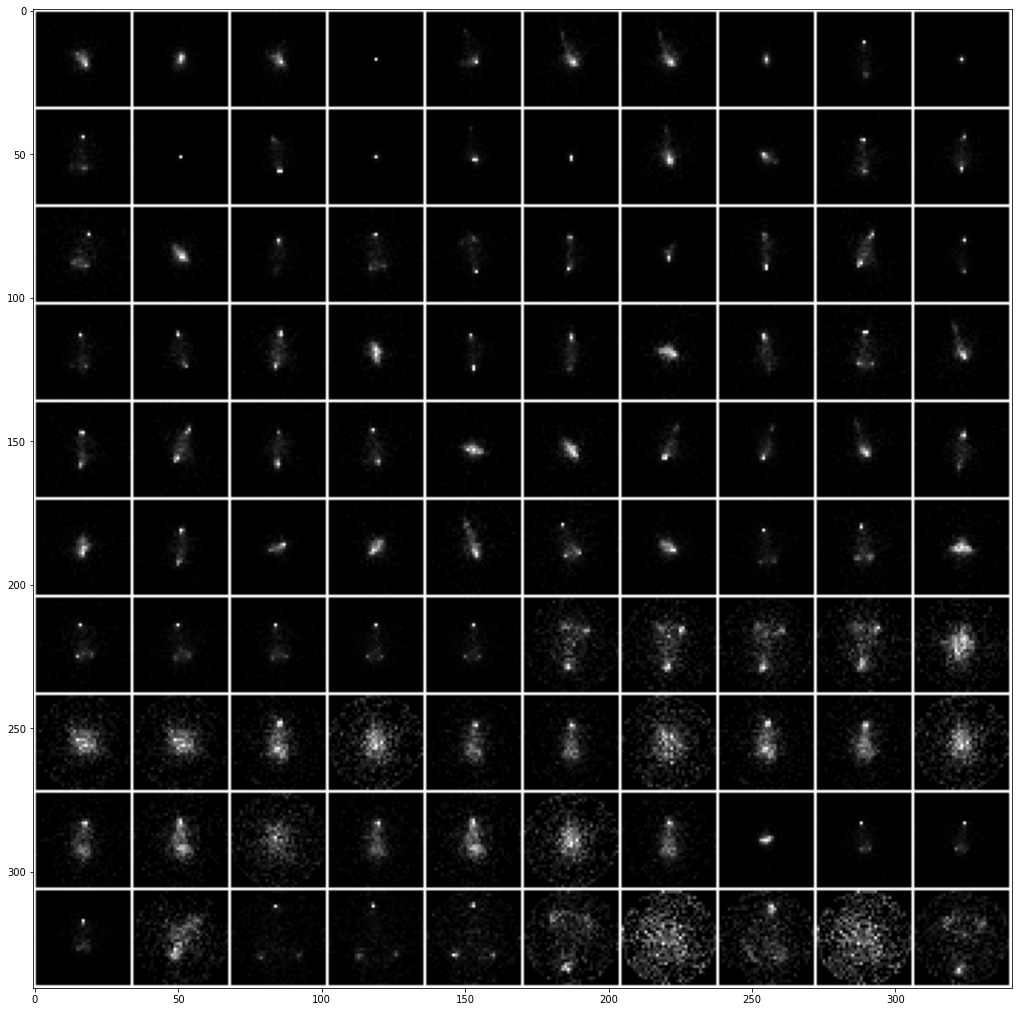

In [0]:
# trainset = create_dataset(100, apply_pca_2d=False)
trainset_test = create_dataset(100)

visualize_dataset(trainset_test, scale_to_plot=-1, n_accumulators=100)

## 3 CNN MODEL

In [0]:
# Build the neural network, expand on top of nn.Module
class HoughTrasnformCnn(nn.Module):
  def __init__(self, scales=1, convolutional=None, dense=None):
    super().__init__()
    # Feature extraction layer
    self.convolutional = nn.Sequential(
      nn.Conv2d(scales, 50, kernel_size=3),
      nn.ReLU(),
      nn.BatchNorm2d(50),
      nn.Conv2d(50, 50, kernel_size=3),
      nn.ReLU(),
      nn.BatchNorm2d(50),
      nn.MaxPool2d(2, 2),
      nn.Conv2d(50, 96, kernel_size=3),
      nn.ReLU(),
      # nn.BatchNorm2d(96),
      nn.MaxPool2d(2, 2)
      )

    # Fully connected layer
    self.dense = nn.Sequential(
      nn.Dropout(),
      nn.Linear(3456, 2048),
      nn.Dropout(),
      nn.ReLU(),
      nn.Linear(2048, 1024),
      nn.Dropout(),
      nn.ReLU(),
      nn.Linear(1024, 512),
      nn.Dropout(),
      nn.ReLU(),
      nn.Linear(512, 2),
    )

  # define forward function
  def forward(self, t):
    t = self.convolutional(t)
    t = t.reshape(-1, 3456)
    t = self.dense(t)

    return t

### 3.1 Training *Tracking* and *Logging*

Class to track the loss and the performance of the training.
Also contains the results of the run such as the best weights for the cnn,
best validation loss e.t.c

In [0]:
# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc.
class TrainingTracker():
  def __init__(self):
    self.epoch_count = 0
    self.epoch_start_time = None

    self.run_start_time = None
    self.run_duration = None
    self.run_data = []

    # track every loss and performance
    self.train_losses = []
    self.valid_losses = []
    
    # Angle error is the sum of all the angles between ground
    # truth and predicted normals
    self.valid_angle_error = []
    self.max_angle_threshold = (2 * np.pi)
    # Count how many ground truth and prediction normals pairs have
    # angle bigger than max_angle_threshold.
    self.valid_wrong_angle_count = []

    self.best_valid_loss = np.inf
    self.is_best_valid_loss_recorded = False
    self.valid_loss = np.inf

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_start_time = None

    # record model, best model weights, loader
    self.net = None
    self.best_net_weights = None
    self.train_loader = None
    self.valid_loader = None
    self.criterion = None
    # self.valid_untrunsformed_normals = None
    # self.valid_pca3_transforms = None
    # self.valid_pca2_transforms = None

    self.do_early_stop = True
    self.early_stop_patience = 20 
    self._times_since_last_best_valid_loss = 0

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def start_run(self, net, params, train_loader, valid_loader, criterion):
    self.run_start_time = time.time()
    
    if 'do_early_stop' in params:
      self.do_early_stop = params['do_early_stop']
    if 'early_stop_patience' in params:
      self.early_stop_patience = params['early_stop_patience']

    self.run_params = params
    self.net = net
    self.train_loader = train_loader
    self.valid_loader = valid_loader
    self.criterion = criterion
    
    # self.valid_untrunsformed_normals = params['valid_untrunsformed_normals']
    # self.valid_pca3_transforms = params['valid_pca3_transforms']
    # self.valid_pca2_transforms = params['valid_pca2_transforms']

  # Also assign the best net weights to the model
  def end_run(self):
    self.run_duration = time.time() - self.run_start_time
    self.net.load_state_dict(self.best_net_weights)
    # Set dropout and batch normalization layers to evaluation mode before running inference
    self.net.eval()
    print("Run duration ", self.run_duration)

  def start_epoch(self):
    self.epoch_start_time = time.time()

  def end_epoch(self):
    self.epoch_count += 1
    self.epoch_duration = time.time()  - self.epoch_start_time

  def display_results(self):
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["epoch"] = self.epoch_count
    # record epoch loss and accuracy
    if self.train_losses:
      loss     = self.train_losses[-1]
      results["train loss"] = loss
    if self.valid_losses:
      results["valid loss"] = self.valid_losses[-1]
    results["Best Loss"]  = self.is_best_valid_loss_recorded

    if self.do_early_stop:
      results["Times since last best loss"] = self._times_since_last_best_valid_loss
      results["Early Stop Patience"] = self.early_stop_patience

    for param_group in  params['optimizer'].param_groups:
      results["lr"] = param_group["lr"]
               
    # Record hyper-params into 'results'
    for k,v in self.run_params.items(): 
      if k not in ["trainset", "validset", "testset", "optimizer"]:
        results[k] = v

    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  @torch.no_grad()
  def load(self, filename, scales):
      model = HoughTrasnformCnn(scales=scales)
      model.load_state_dict(torch.load(filename))
      model.eval()

      f = open(self.filename, 'rb')
      tmp_dict = cPickle.load(f)
      f.close()          
      self.__dict__.update(tmp_dict) 

  @torch.no_grad()
  def save(self, output_name):
      torch.save(self.net.state_dict(), f'{output_name}.pt')
      
      f = open(output_name, 'wb')
      cPickle.dump(self.__dict__, f, 2)
      f.close()
      
  
  @torch.no_grad()
  # accumulate loss of batch into entire epoch loss
  def track_loss(self, train_loss=None):
    if train_loss is None:
      train_loss = self._get_loss(self.train_loader) 
    self.train_losses.append(train_loss)
 

    # self.angle_sum, self.n_wrong = self._get_angle_error(self.valid_loader)
    valid_loss = self._get_loss(self.valid_loader) 
    self.valid_losses.append(valid_loss)
    self.valid_loss = valid_loss
    if valid_loss < self.best_valid_loss:
      self.best_net_weights = deepcopy(self.net.state_dict())
      self.is_best_valid_loss_recorded = True
      self.best_valid_loss = valid_loss
      self._times_since_last_best_valid_loss = 0
    else :
      self.is_best_valid_loss_recorded = False
      self._times_since_last_best_valid_loss += 1
        
  def should_early_stop(self):
    return self.do_early_stop and self._times_since_last_best_valid_loss >= self.early_stop_patience
    
  @torch.no_grad()
  # def _get_angle_error(self, loader):
  #   n_samples = 0

  #   for batch in loader:
  #     images = batch[0].to(device)
  #     targets = batch[1].to(device)

  #     predictions = self.net(images).cpu().numpy().squeeze()
  #     # get_normal_from_prediction(predictions, self.valid_pca3_transforms, self_valid_pca2_transforms)
  #     get_normal_from_prediction(predictions, self.valid_pca3_transforms, self_valid_pca2_transforms)

  #     get_angle_error(predictions, )
  #     self.valid_untrunsformed_normals
  #     n_samples += targets.shape[0]

  @torch.no_grad()
  def _get_loss(self, loader):
    total_loss=0
    n_samples = 0

    for batch in loader:
      images = batch[0].to(device)
      targets = batch[1].to(device)

      predictions = self.net(images)
      loss = self.criterion(predictions, targets)

      n_samples += targets.shape[0]
      total_loss += loss.item()

    total_loss /= n_samples
    
    return total_loss

### 3.2 Training Routine

#### train

In [0]:
def train(cnn, params):

  # if params changes, following line of code should reflect the changes too
  train_loader = torch.utils.data.DataLoader(
                                       params['trainset'], 
                                       batch_size = params['batch_size'],
                                       shuffle=True
                                       )
    
  valid_loader = torch.utils.data.DataLoader(
                                       params['validset'], 
                                       batch_size = params['batch_size'],
                                       shuffle=False
                                       )

  epochs = params['epochs']

  if 'optimizer' not in params:
    assert 'lr' in params
    params['optimizer'] = optim.Adam(cnn.parameters(), lr=params['lr'])
  optimizer = params['optimizer']

  if 'learning_rate_scheduler_patience' not in params:
        if 'early_stop_patience' in params:
            params['learning_rate_scheduler_patience'] = int(0.5 * params['early_stop_patience'])
        else:
            params['learning_rate_scheduler_patience'] = 10                                              
  learning_rate_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                                       'min', patience=params['learning_rate_scheduler_patience'])
  criterion = nn.MSELoss()
  t = TrainingTracker()
  t.start_run(cnn, params, train_loader, valid_loader,  criterion)
    
    
  for epoch in tqdm(range(epochs)):
    
    if t.should_early_stop():
      break
      
    t.start_epoch()
    total_loss = 0
    n_samples = 0
    for batch in train_loader:
      # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
      optimizer.zero_grad()

      accumulators = batch[0].to(device)
      train_normals =  batch[1].to(device) 

      predicted_normals = cnn(accumulators)

      loss = criterion(predicted_normals, train_normals)
      total_loss += loss.item()

      n_samples += accumulators.shape[0]
      
      loss.backward()
      optimizer.step()

    total_loss /= n_samples
    if epoch  % 1 == 0 or epoch == epochs-1:
      t.track_loss(total_loss)
      t.display_results()
      learning_rate_scheduler.step(t.valid_loss)
    t.end_epoch()

    
  t.end_run()

  return t

### 3.3 Test helpers


In [0]:
from math import acos

def get_normal_from_prediction(pred_n, pca_obj_3d=None, pca_obj_2d=None, expected_orientation=np.array([0, 0, 1])):
  x = pred_n[0]
  y = pred_n[1]
  # Because of float issues sometimes the value inside sqrt is <0 
  # -> clip to 0..1
  z = np.sqrt(np.clip(1 - (x**2 + y**2), 0, 1))
  

  # Derivation:
  # (sqrt(x**2 + y**2 + z**2))**2 = (1)**2
  # x**2 + y**2 + z**2 = 1
  # z**2 = 1 - (x**2 + y**2)
  # sqrt(z**2) = sqrt(1 - (x**2 + y**2))
  # z = +- sqrt(1 - (x**2 + y**2))

  normal = np.array([x, y, z])
  normal = get_oriented_normals(normal, expected_orientation)
  normal /= np.sqrt(np.clip(np.dot(normal, normal), 1e-16, 1))
  
  if pca_obj_2d is not None:
    # print("applying 2d pca")
    if type(pca_obj_2d) == np.ndarray:
      normal = pca_obj_2d.T @ normal
    else:
      normal = pca_obj_2d.inverse_transform(normal)

  if pca_obj_3d is not None:
    # print("applying 3d pca") 
    if type(pca_obj_3d) == np.ndarray:
      normal = pca_obj_3d.T @ normal
    else:
      normal = pca_obj_3d.inverse_transform(normal)

  normal = get_oriented_normals(normal, expected_orientation)
  normal /= np.sqrt(np.clip(np.dot(normal, normal), 1e-16, 1))
  return normal

def predict_normals(model, point_cloud,
                    n_points_per_neighborhood=100,
                    scales=5,
                    expected_orientation=np.array([0, 0, 1]),
                    apply_pca_3d=True,
                    apply_pca_2d=True):
  expected_orientation = np.squeeze(expected_orientation)
  assert expected_orientation.ndim == 2 or expected_orientation.ndim == 1

  hough_accumulators = np.zeros([point_cloud.shape[0], 33, 33, scales])
  kd_tree = KDTree(point_cloud, metric="euclidean")
  predictions = np.zeros_like(point_cloud)
  # create_accumulator for each point
  for curr_point_idx in range(point_cloud.shape[0]):
    # Expected orientation can be one vector or an array of vectors.
    # In case of the array there must be one vector for each point.
    if expected_orientation.ndim == 2:
      curr_expected_orientation = expected_orientation[curr_point_idx, :]
    else:
      curr_expected_orientation = expected_orientation

    accum_votes, pca_obj_3d, pca_obj_2d = create_multiscale_accumulator(point_cloud,
                                                curr_point_idx,
                                                kd_tree=kd_tree,
                                                scales=scales,                      
                                                apply_pca_3d=apply_pca_3d,
                                                apply_pca_2d=apply_pca_2d,
                                                accumulator_size=33)
    # Fill in the training sample 
    hough_accumulators[curr_point_idx, ...]  = accum_votes
    # import pdb; pdb.set_trace()
    with torch.no_grad():
      # Turn hough image to torch tensor that is compliant with our network.
      # The input shape should be BatchSize,Channels,AccumSize,AccumSize
      hough_image = accum_votes[np.newaxis, ...]
      hough_image = torch.from_numpy(hough_image).to(device)
      hough_image = hough_image.permute(0, -1, 1, 2) # Bring channel dim to expected position
      hough_image = hough_image.type(torch.FloatTensor).to(device)
      predicted_normal = model(hough_image)
      # Output shape is BatchSize,2
      # Output vector is the transformer normal.
      # We must bring transform it back.
      predicted_normal = predicted_normal.cpu().numpy().squeeze()
      predicted_normal = get_normal_from_prediction(predicted_normal,
                                                    pca_obj_3d,
                                                    pca_obj_2d,
                                                    expected_orientation=curr_expected_orientation)
      # TODO: REMOVE AFTER                                                    
      # print("Predicted Normal", predicted_normal)                                                    
      # print("Ground Truth", curr_expected_orientation)
      predictions[curr_point_idx, :] = predicted_normal

  # predictions = model(hough_accumulators)
  # Nx3
  return predictions


def get_2d_normal_from_accumulator(accumulator, accumulator_size=33):
    x, y = np.unravel_index(np.argmax(accumulator), accumulator.shape)

    nx = ((2 * x)/(accumulator_size-1)) - 1
    ny = ((2 * y)/(accumulator_size-1)) - 1

    return np.array([nx, ny])


def predict_normals_max_bin(point_cloud,
                            normals=None,
                            apply_pca_3d=True,
                            apply_pca_2d=True,
                            expected_orientation=np.array([0, 0, 1]),
                            n_points_per_neighborhood = 100):
  if normals is not None:
    assert point_cloud.shape[0] == normals.shape[0]
    
  if n_points_per_neighborhood > point_cloud.shape[0]:
    n_points_per_neighborhood = point_cloud.shape[0]

  kd_tree = KDTree(point_cloud, metric='euclidean')

  predictions = np.zeros_like(point_cloud)
  # create_accumulator for each point
  for i in range(point_cloud.shape[0]):
    curr_point = point_cloud[i]
    curr_point = curr_point[np.newaxis, :]

    curr_normal = expected_orientation
    if normals is not None:
      curr_normal = normals[i]
    # print(curr_normal)
    
    _, point_neighbors_idx = kd_tree.query(curr_point, k=n_points_per_neighborhood)
    neighborhood =  np.squeeze(point_cloud[point_neighbors_idx])
    
    accum_votes, pca_obj_3d, pca_obj_2d = create_accumulator_vectorised(neighborhood,
                                                apply_pca_3d=apply_pca_3d,
                                                apply_pca_2d=apply_pca_2d,
                                                accumulator_size=33,
                                                expected_orientation=curr_normal)

    predicted_normal = get_2d_normal_from_accumulator(accum_votes)
    predicted_normal = get_normal_from_prediction(predicted_normal,
                                                  pca_obj_3d,
                                                  pca_obj_2d,
                                                  expected_orientation=curr_normal)
    predictions[i, :] = predicted_normal

  return predictions

import matplotlib as mpl
import matplotlib.cm as cm

# z axis points upwards
def visualize_error(point_cloud, 
                    predicted_normals, 
                    ground_truth_normals,
                    pgp_error_degress=8, 
                    title="Angle error"):
  norm = mpl.colors.Normalize(vmin=0, vmax=1)
  cmap = cm.jet # RdYlGn
  m = cm.ScalarMappable(norm=norm, cmap=cmap)

  colors = np.zeros_like(point_cloud)
  for i in range(len(point_cloud)):
    point = point_cloud[i]
    predicted_normal = predicted_normals[i]
    ground_truth_normal = ground_truth_normals[i]

    dot = np.clip(predicted_normal @ ground_truth_normal, -1, 1)
    # print(dot)
    # ||predicted_normal|| * ||ground_truth_normal|| * cos(theta) 
    theta = acos(dot)
    
    # print(theta)
    val = (theta / (np.pi))
    # rgba = m.to_rgba((theta / (np.pi)))
    rgb = np.array([val, 1-val, 0])
    colors[i, :] = np.array(rgb)

  rms, n_good_points, good_points_idx = get_angle_error(predicted_normals, 
                                                        ground_truth_normals, 
                                                        pgp_threshold=math.radians(pgp_error_degress))
  title += f"<br>rms: {rms:.4f}"
  title += f"<br>Point Cloud size: {point_cloud.shape[0]}"
  title += f"<br>good points (angle < {pgp_error_degress} deg): {n_good_points}"
  title += f"<br>good points ratio: {((n_good_points * 100)/point_cloud.shape[0]):.2f}%"

  colors[good_points_idx, :] = np.array([0, 0, 1])
  return visualize_point_cloud(point_cloud, colors=colors, title=title)

#### plot_results

In [0]:
def plot_results(results):
  fig = plt.figure(figsize=(13,8))
  train_plot = plt.plot(results.train_losses, label="Training loss")
  valid_plot = plt.plot(results.valid_losses, label="Validation loss")
  plt.legend(["Training Loss", "Validation Loss"])

  best_valid_loss_idx = np.argmin(results.valid_losses)
  best_valid_loss = np.min(results.valid_losses)
  
  best_train_loss_idx = np.argmin(results.train_losses)
  best_train_loss = np.min(results.train_losses)
  
  plt.scatter(best_valid_loss_idx, best_valid_loss, marker="*")
  plt.annotate('{:.2f}'.format(best_valid_loss), (best_valid_loss_idx, best_valid_loss))


### 3.4 Training

#### Scales

In [0]:
np.seterr('warn')
scales=3
trainset = create_dataset(25000, scales=scales)
validset = create_dataset(1000, scales=scales)

  0%|          | 0/25000 [00:00<?, ?it/s]


Target 3-corner:  10750
Target 2-corner:  10750
Target 1-corner:  3500


 59%|█████▉    | 14826/25000 [01:11<03:10, 53.36it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in double_scalars

 62%|██████▏   | 15539/25000 [01:25<02:59, 52.75it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in double_scalars

 63%|██████▎   | 15843/25000 [01:32<04:20, 35.21it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in double_scalars

 72%|███████▏  | 17977/25000 [02:16<02:20, 50.03it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in double_scalars

 73%|███████▎  | 18280/25000 [02:23<01:58, 56.77it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in double_scalars

 74%|███████▎  | 18400/25000 [02:25<01:31, 72.31it/s]/usr/local/lib/python3.6/dist-packages/ipykerne


Generated 3500 planes
Generated 10750 2-corners
Generated 10750 3-corners
(25000, 33, 33, 3)

Target 3-corner:  430
Target 2-corner:  430
Target 1-corner:  140


100%|██████████| 1000/1000 [00:11<00:00, 85.61it/s]


Generated 140 planes
Generated 430 2-corners
Generated 430 3-corners
(1000, 33, 33, 3)


torch.Size([100, 1, 33, 33])


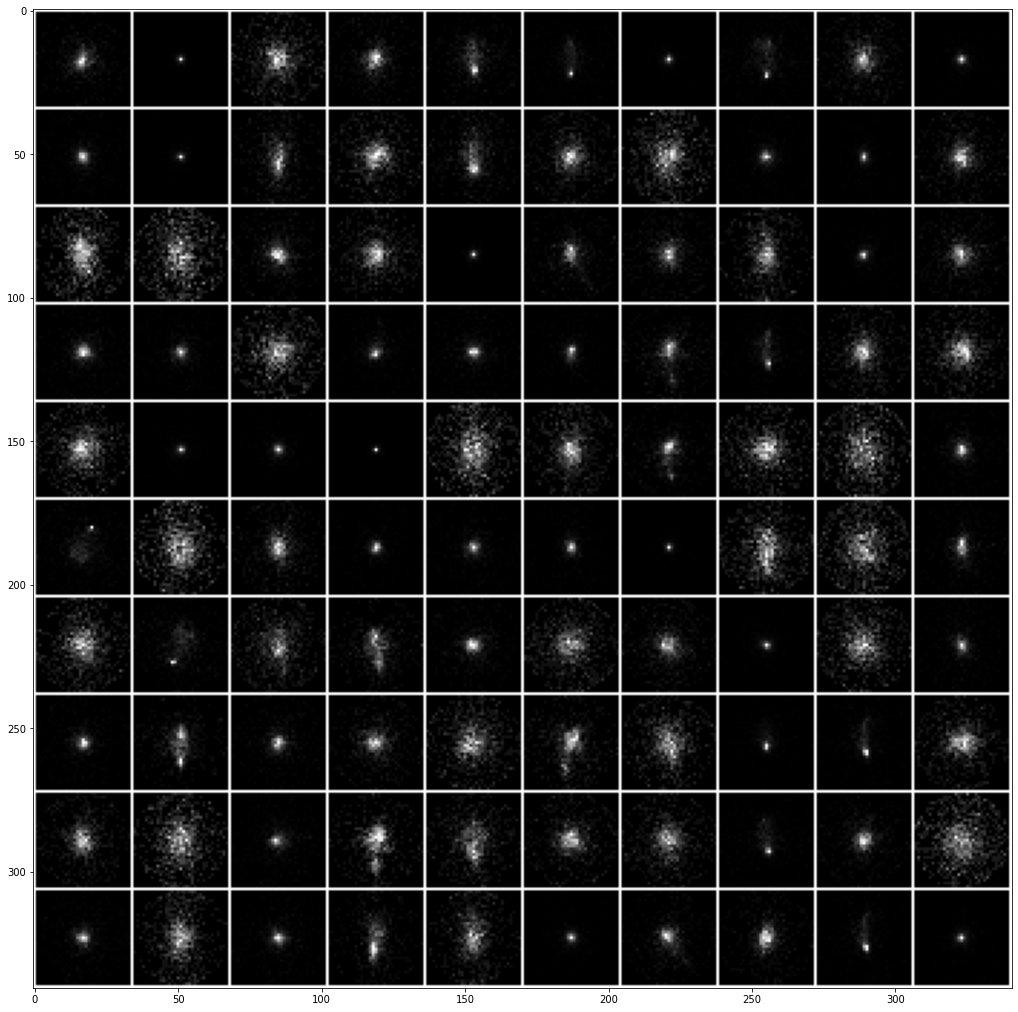

In [0]:
visualize_dataset(trainset, scale_to_plot=-1, n_accumulators=100)

#### TEST MODEL

In [0]:
model = HoughTrasnformCnn(scales=scales).to(device)
results = None
params = OrderedDict(
    # lr = .001, 
    optimizer = optim.SGD(model.parameters(), lr=.001, weight_decay=1e-6, momentum=0.9),
    # optimizer = optim.SGD(model.parameters(), lr=.001, weight_decay=5e-5, momentum=0.9),
    # optimizer = optim.Adam(model.parameters(), lr=.001, weight_decay=3e-6),
    batch_size = 525,
    do_early_stop=True, # Optional default True
    early_stop_patience=40,
    learning_rate_scheduler_patience=4,
    epochs = 100,
    shuffle = True,
    # valid_untrunsformed_normals = valid_untrunsformed_normals,
    trainset = trainset,
    validset = validset,
)

results = train(model, params)

epoch  train loss  ...  epochs  shuffle
0       0    0.000232  ...     100     True
1       1    0.000222  ...     100     True
2       2    0.000217  ...     100     True
3       3    0.000214  ...     100     True
4       4    0.000211  ...     100     True
..    ...         ...  ...     ...      ...
75     75    0.000199  ...     100     True
76     76    0.000199  ...     100     True
77     77    0.000199  ...     100     True
78     78    0.000200  ...     100     True
79     79    0.000200  ...     100     True

[80 rows x 13 columns]

 80%|████████  | 80/100 [02:38<00:39,  1.99s/it]

Run duration  158.40924310684204


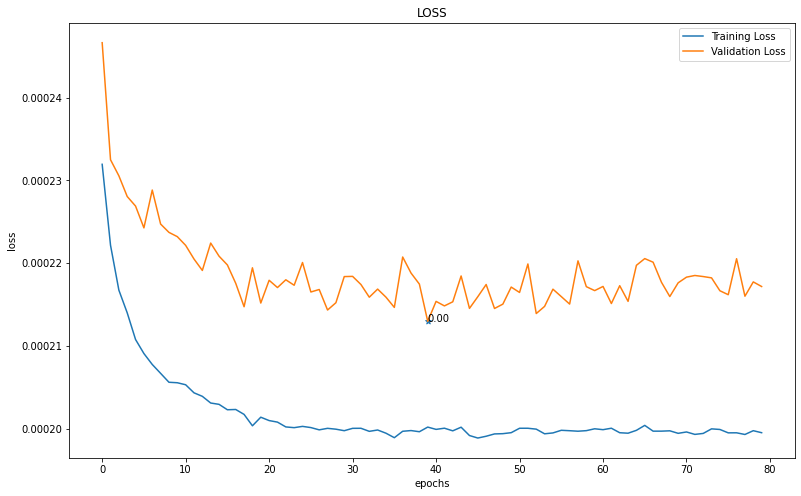

In [0]:
plot_results(results)
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('loss-lr-001-weight_decay-0.000001-momentum-0.9_learning_rate_scheduler_patience=4.svg')

In [0]:
torch.save(results.net.state_dict(), '.\output_good.pt')

In [0]:
trained_model = results.net

#### Show results

In [0]:
corner_points, corner_normals = create_corner(5000, angle=100)
# corner_points = apply_noise(corner_points, noise_scale=2)
corner_points, corner_normals = apply_random_rotation(corner_points, corner_normals)
corner_points = apply_noise(corner_points, noise_scale=30)
visualize_point_cloud(corner_points).show()

In [0]:
maxbin_normals = predict_normals_max_bin(corner_points, corner_normals, n_points_per_neighborhood=100)
visualize_error(corner_points, maxbin_normals, corner_normals, title="Max Bin")

In [0]:
# untrained_predicted_normals = predict_normals(untrained_model, corner_points, scales=scales)
trained_predicted_normals = predict_normals(trained_model, corner_points,  scales=scales)
visualize_error(corner_points, trained_predicted_normals, corner_normals, title="CNN").show()

In [0]:
# Not noisy
corner_points, corner_normals = create_corner(5000, angle=100)
# corner_points = apply_noise(corner_points, noise_scale=2)
corner_points, corner_normals = apply_random_rotation(corner_points, corner_normals)
visualize_point_cloud(corner_points).show()

In [0]:
maxbin_normals = predict_normals_max_bin(corner_points, corner_normals, n_points_per_neighborhood=100)
visualize_error(corner_points, maxbin_normals, corner_normals, title="Max Bin")

In [0]:
trained_predicted_normals = predict_normals(trained_model, corner_points,  scales=scales)
visualize_error(corner_points, trained_predicted_normals, corner_normals, title="CNN")

Warning,  terrain.obj mesh should be placed in the current working directory path

In [0]:
mesh = trimesh.load_mesh('terrain.obj')
terrain_vertices = np.array(mesh.vertices)
terrain_normals = np.array(mesh.vertex_normals)
terrain_vertices = apply_noise(terrain_vertices, noise_scale=30)

ValueError: ignored

In [0]:
untrained_predicted_normals = predict_normals(untrained_model, terrain_vertices, scales=scales)
trained_predicted_normals = predict_normals(trained_model, terrain_vertices,  scales=scales)
maxbin_normals = predict_normals_max_bin(terrain_vertices, n_points_per_neighborhood=100)

In [0]:
maxbin_normals = predict_normals_max_bin(corner_points, corner_normals)
visualize_error(corner_points, maxbin_normals, corner_normals)

### 3.4 Evaluation

#### Terrain obj

In [0]:
mesh = trimesh.load_mesh('terrain_sm.obj')
terrain_vertices = np.array(mesh.vertices)
terrain_normals = np.array(mesh.vertex_normals)
terrain_vertices.shape

In [0]:
points  = terrain_vertices
normals = terrain_normals

rms_max_bin_res = []
good_points_max_bin = []
good_points_ratio_max_bin = []

rms_cnn_res = []
good_points_cnn = []
good_points_ratio_cnn = []

n_points = points.shape[0]

for i in range(50):
  points_noise = apply_noise(points, noise_scale=i)

  # Max bin evaluation
  max_bin_normals = predict_normals_max_bin(points_noise)
  rms_max_bin, n_gp_max_bin, _ = get_angle_error(max_bin_normals, normals)

  rms_max_bin_res.append(rms_max_bin)
  good_points_max_bin.append(n_gp_max_bin)
  good_points_ratio_max_bin.append(n_gp_max_bin/n_points)

  # CNN evaluation
  cnn_normals = predict_normals(trained_model, points_noise,  scales=scales)
  rms_cnn, n_gp_cnn, _ = get_angle_error(cnn_normals, normals)

  rms_cnn_res.append(rms_cnn)
  good_points_cnn.append(n_gp_cnn)
  good_points_ratio_cnn.append(n_gp_cnn/n_points)

In [0]:
fig = plt.figure(figsize=(20,10))
plt.title('Root Mean Square (RMS)')
plt.xlabel('Noise Level')
plt.ylabel('RMS')

max_bin_rms_fig, = plt.plot(rms_max_bin_res, label="Max bin")#, xlabel="Noise Level", ylabel="RMS")
cnn_rms_fig, = plt.plot(rms_cnn_res, label="Trained network")
plt.legend(handles=[max_bin_rms_fig, cnn_rms_fig])
plt.savefig('rms-error-terrain.svg')

In [0]:
fig = plt.figure(figsize=(20,10))
plt.title('Good points ratio comparison (angle < 8 degrees)')
plt.xlabel('Noise Level')
plt.ylabel('Good Point Ratio ')

max_bin_rms_fig, = plt.plot(good_points_ratio_max_bin, label="Max bin")#, xlabel="Noise Level", ylabel="RMS")
cnn_rms_fig, = plt.plot(good_points_ratio_cnn, label="CNN")
plt.legend(handles=[max_bin_rms_fig, cnn_rms_fig])
plt.savefig('good-point-ratio-terrain.svg')

In [0]:
corner_points, corner_normals = create_corner(n_points=1000, angle=75)
visualize_point_cloud(corner_points)

In [0]:
points  = corner_points
normals = corner_normals  

rms_max_bin_res = []
good_points_max_bin = []
good_points_ratio_max_bin = []

rms_cnn_res = []
good_points_cnn = []
good_points_ratio_cnn = []

n_points = points.shape[0]

for i in range(50):
  points_noise = apply_noise(points, noise_scale=i)

  # Max bin evaluation
  max_bin_normals = predict_normals_max_bin(points_noise)
  rms_max_bin, n_gp_max_bin, _ = get_angle_error(max_bin_normals, normals)

  rms_max_bin_res.append(rms_max_bin)
  good_points_max_bin.append(n_gp_max_bin)
  good_points_ratio_max_bin.append(n_gp_max_bin/n_points)

  # CNN evaluation
  cnn_normals = predict_normals(trained_model, points_noise,  scales=scales)
  rms_cnn, n_gp_cnn, _ = get_angle_error(cnn_normals, normals)

  rms_cnn_res.append(rms_cnn)
  good_points_cnn.append(n_gp_cnn)
  good_points_ratio_cnn.append(n_gp_cnn/n_points)

In [0]:
fig = plt.figure(figsize=(20,10))
plt.title('Root Mean Square (RMS)')
plt.xlabel('Noise Level')
plt.ylabel('RMS')

max_bin_rms_fig, = plt.plot(rms_max_bin_res, label="Max bin")#, xlabel="Noise Level", ylabel="RMS")
cnn_rms_fig, = plt.plot(rms_cnn_res, label="Trained network")
plt.legend(handles=[max_bin_rms_fig, cnn_rms_fig])
plt.savefig('rms-error-corner.svg')

In [0]:
fig = plt.figure(figsize=(20,10))
plt.title('Good points ratio comparison (angle < 8 degrees)')
plt.xlabel('Noise Level')
plt.ylabel('Good Point Ratio ')

max_bin_rms_fig, = plt.plot(good_points_ratio_max_bin, label="Max bin")#, xlabel="Noise Level", ylabel="RMS")
cnn_rms_fig, = plt.plot(good_points_ratio_cnn, label="CNN")
plt.legend(handles=[max_bin_rms_fig, cnn_rms_fig])
plt.savefig('good-point-ratio-corner.svg')